# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "2n_0m_2f_230523_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [70, 1840]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 108060
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,538.663366,48.925743,534.126553,50.729699,NaN,538.663366,48.925743,NaN,538.663366,48.925743,-1.354405,202.0,198.637945,37.674952,0.981849,3
1,1,0,646.642370,89.409104,644.761313,90.350212,0.0,632.000000,42.000000,0.521569,659.000000,92.000000,1.463937,10413.0,180.429392,97.886212,0.840044,3
2,2,0,1206.636064,789.249676,1200.223249,791.793251,NaN,1206.636064,789.249676,NaN,1206.636064,789.249676,-1.360824,10021.0,158.530084,93.553364,0.807308,3
3,0,3,538.767327,48.995050,534.382783,50.758810,NaN,538.767327,48.995050,NaN,538.767327,48.995050,-1.350884,202.0,198.682511,38.301010,0.981243,3


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([1, 2])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1]
    ])

    cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
    print("Initial tracking at time 0:\n", tracking_0[cols])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x  position_y  orientation
1   0     0         3   646.642370   89.409104     1.463937
2   1     0         3  1206.636064  789.249676     1.360824


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
1,0,0,646.642370,89.409104,644.761313,90.350212,0.0,632.000000,42.000000,0.521569,659.000000,92.000000,1.463937,10413.0,180.429392,97.886212,0.840044,3
2,1,0,1206.636064,789.249676,1200.223249,791.793251,NaN,1206.636064,789.249676,NaN,1206.636064,789.249676,1.360824,10021.0,158.530084,93.553364,0.807308,3
3,0,3,538.767327,48.995050,534.382783,50.758810,NaN,538.767327,48.995050,NaN,538.767327,48.995050,-1.350884,202.0,198.682511,38.301010,0.981243,3
4,1,3,645.759512,89.618131,643.081973,91.076178,NaN,645.759512,89.618131,NaN,645.759512,89.618131,1.480560,10645.0,181.800146,99.566962,0.836693,3
5,2,3,1177.767809,787.589802,1167.159018,790.019532,0.0,1233.000000,739.000000,0.650980,1228.000000,820.000000,-1.430290,11904.0,211.630360,94.265437,0.895319,3


## Velocities distribution in each frame

In [7]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


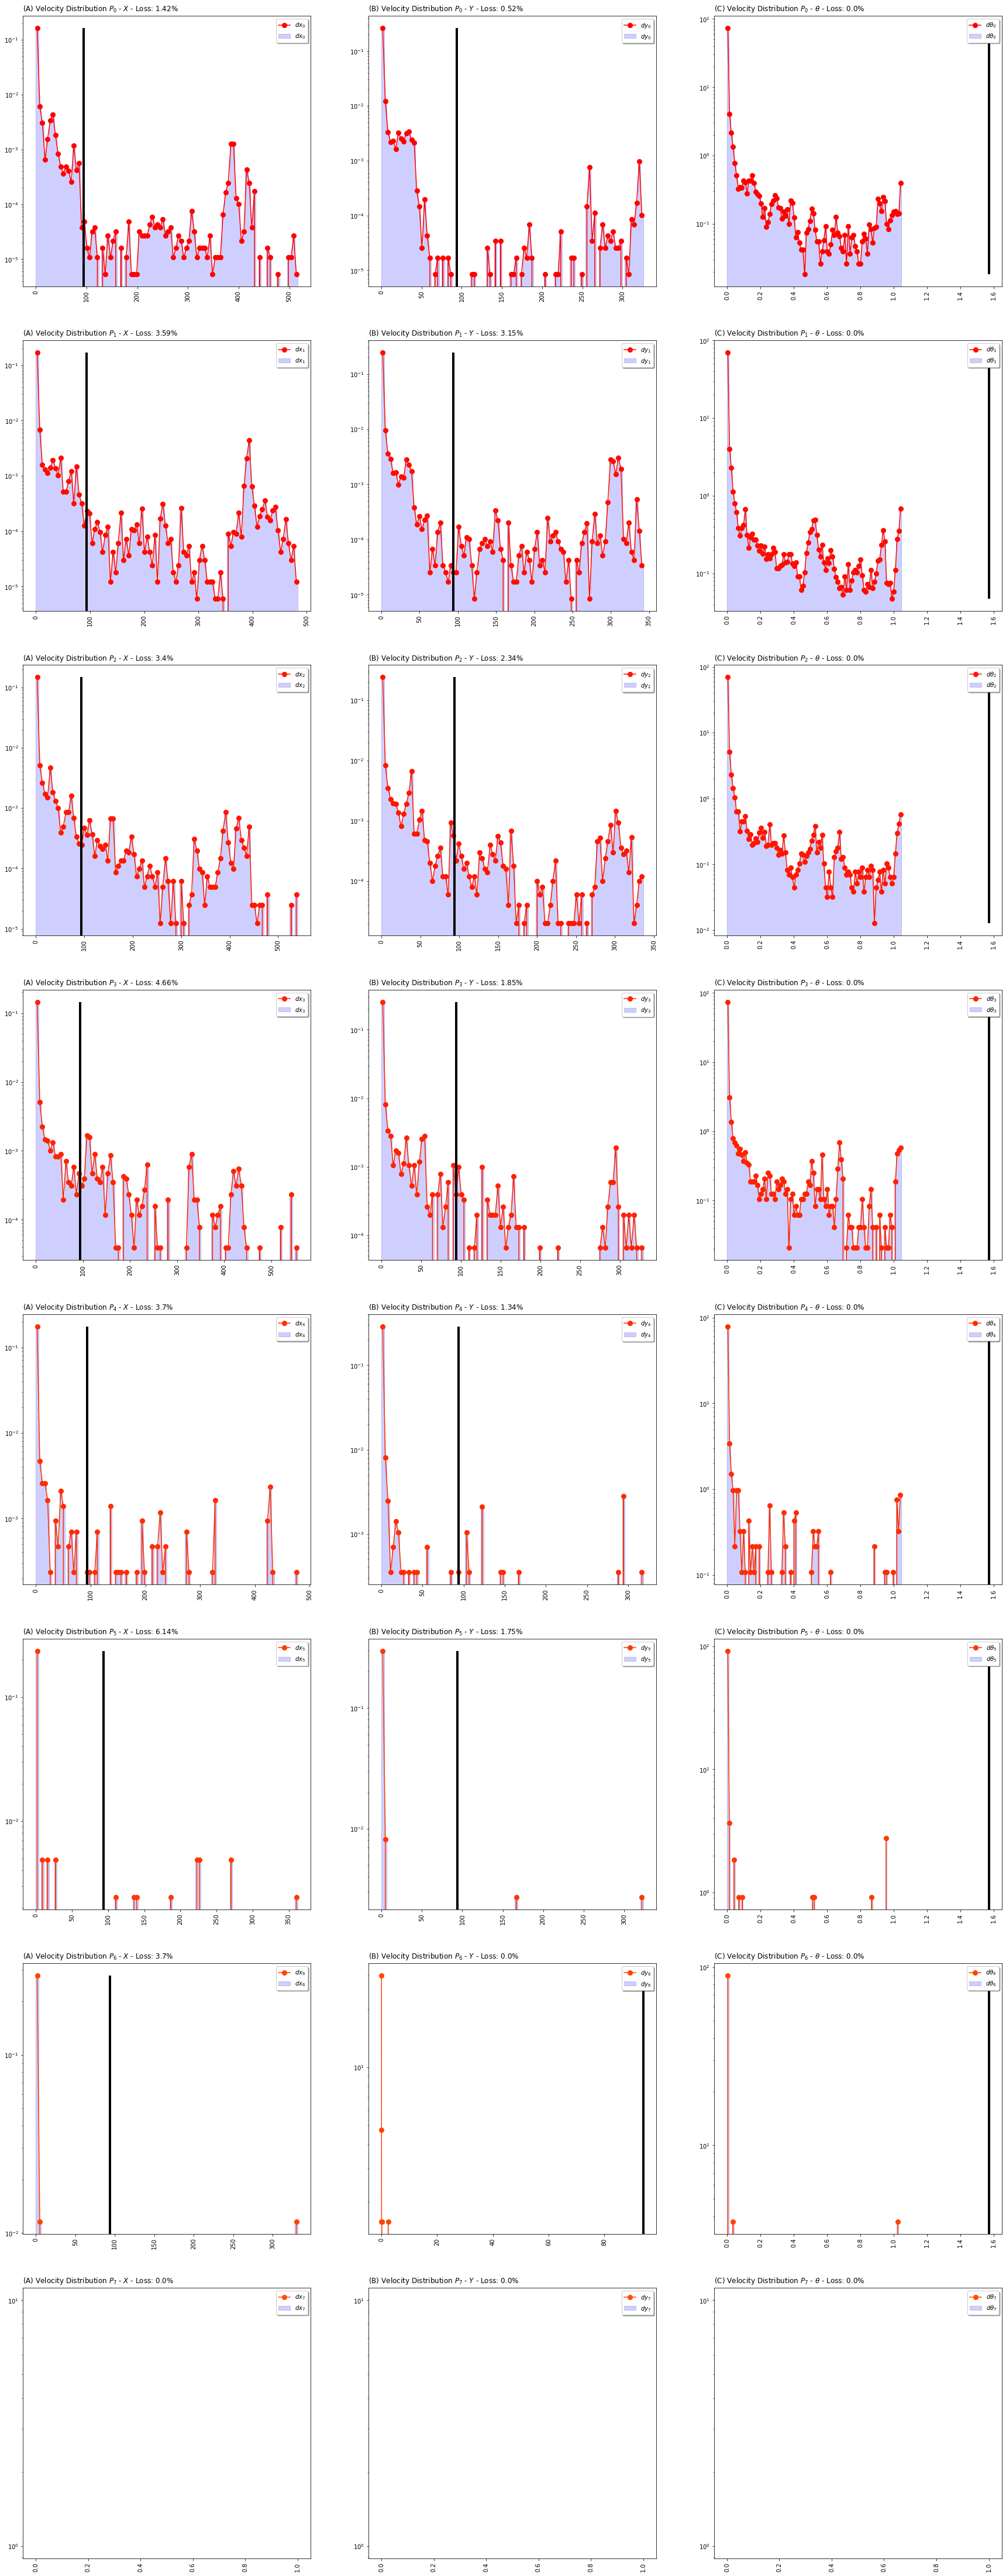

In [8]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [9]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,1,1824
1,2,38476
2,3,31091
3,4,14804
4,5,3895
5,6,522
6,7,182
7,8,8


## Clustering frames

In [10]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 45.09115209922765 



In [11]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [12]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,1,False,False,False,2.008766
1,2,False,False,False,41.018920
2,2,False,True,False,0.180613
3,2,True,False,False,0.233475
4,2,True,True,False,0.940508
5,3,False,False,False,33.194203
6,3,False,True,False,0.149776
7,3,True,False,False,0.509901
8,3,True,True,False,0.386555
9,4,False,False,False,15.748552


In [13]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 4.718581753380148 
	- Angle: 45.09115209922765 



In [14]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.0041648734572614565%
Final loss data X-axis: 10.501034276908554%
Final loss data Y-axis: 7.89104691035804%
Final loss data Angle : 2.367036414876928%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,1,True,True,True,0.004165
1,2,False,False,False,0.544210
2,2,False,False,True,5.733642
3,2,False,True,False,0.530327
4,2,False,True,True,3.692854
5,2,True,False,False,0.052755
6,2,True,False,True,1.560439
7,2,True,True,False,1.239744
8,2,True,True,True,86.641863


In [15]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 4.718581753380148 
	- Angle: 45.09115209922765 



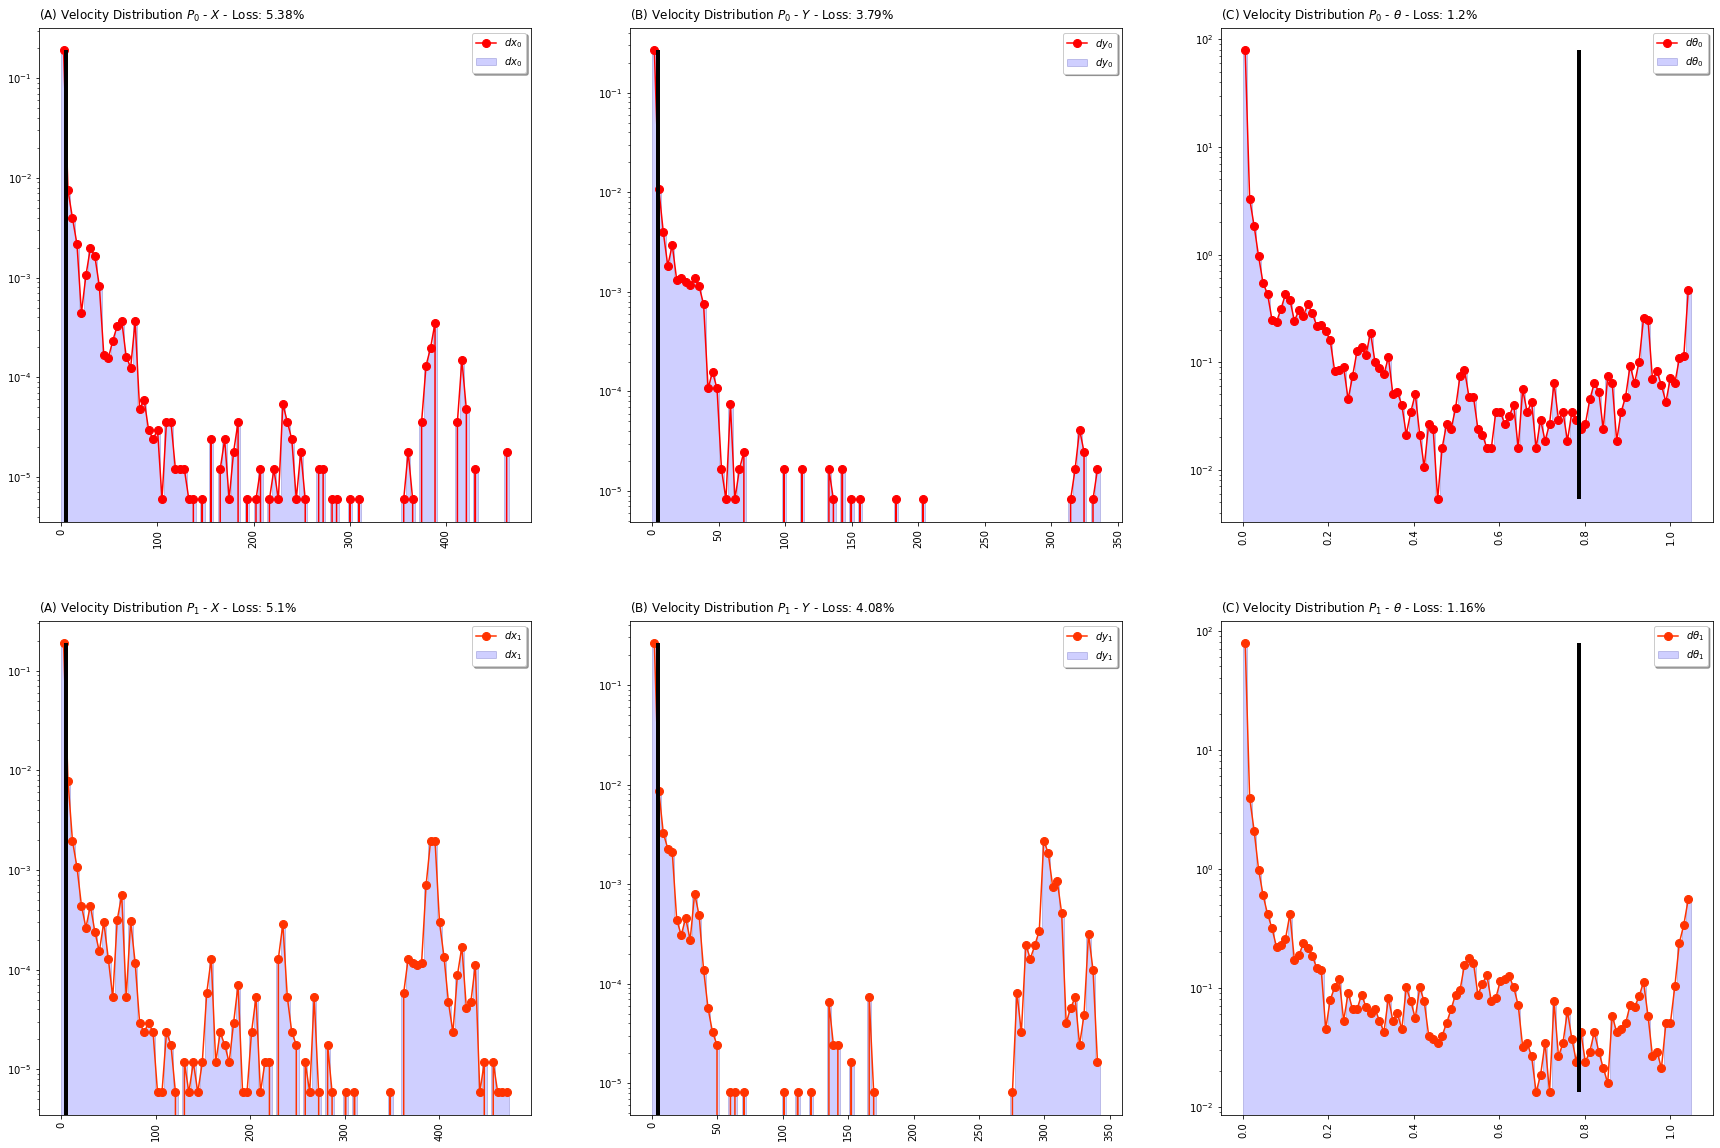

In [16]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [17]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [18]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,646.642370,89.409104,644.761313,90.350212,0.0,632.000000,42.000000,0.521569,659.000000,92.000000,1.463937,10413.0,180.429392,97.886212,0.840044,2,NaN,NaN,NaN,NaN,False,False,False
19236,1,0,1206.636064,789.249676,1200.223249,791.793251,NaN,1206.636064,789.249676,NaN,1206.636064,789.249676,1.360824,10021.0,158.530084,93.553364,0.807308,2,NaN,NaN,NaN,NaN,False,False,False
38469,0,3,645.759512,89.618131,643.081973,91.076178,NaN,645.759512,89.618131,NaN,645.759512,89.618131,1.480560,10645.0,181.800146,99.566962,0.836693,2,3.0,-0.294286,0.069676,0.005541,False,False,False
38470,1,3,1177.767809,787.589802,1167.159018,790.019532,0.0,1233.000000,739.000000,0.650980,1228.000000,820.000000,-1.430290,11904.0,211.630360,94.265437,0.895319,2,3.0,-9.622752,-0.553291,-0.930371,False,False,False
1,0,6,623.644455,86.604658,619.511271,87.426890,NaN,623.644455,86.604658,NaN,623.644455,86.604658,1.459785,12966.0,256.365136,97.362719,0.925076,2,3.0,-7.371686,-1.004491,-0.006925,False,False,False
19237,1,6,1144.255987,784.640313,1135.649507,784.948112,0.0,1103.000000,723.000000,0.627451,1184.000000,729.000000,-1.524943,13028.0,209.482472,97.487639,0.885114,2,3.0,-11.170607,-0.983163,-0.031551,False,False,False


## Visualize final data

In [19]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


In [20]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/2n_0m_2f_230523_1_c.zip'